# **GROUPWORK 3: Potential Outcomes and RCTs** \
**Group's name:** \
**Group 5**

**Group's members:** \
**- Edmar Quispe** \
**- Michael Medina** \
**- Claudia Vivas** \
**- Claudio Cabrera**

## **Multicolinearity**

### **Definition**
In short, multicollinearity is the high (but not perfect) correlation between  two or more independent variables.

the failure of the **full rank** assumption to be complied. \

In principle, the compliance of a system of variables and observations —such as the dataset we want to estimate models on— to possess full rank implies that there is no exact linear relationship among any of the independent variables in the model. \

In practical terms, we wish to be sure that for a random sample of $n$ drawn from this process, ($y_{1}$, $x'_{1}$), ($y_{2}$, $x'_{2}$), ...,  ($y_{n}, x'_{n}$), that the $n*K$ matrix $X$ with $n$ rows $x'_{i}$ always has rank $K$ if $n >= K$. . When this assumption is not met, the model is not estimable, regardless of the sample size. \ 

Having explain that, 


## **2. Analyzing RCT data with Precision Adjustment**

### **Data**

Data
In this lab, we analyze the Pennsylvania re-employment bonus experiment, which was previously studied in "Sequential testing of duration data: the case of the Pennsylvania ‘reemployment bonus’ experiment" (Bilias, 2000), among others. These experiments were conducted in the 1980s by the U.S. Department of Labor to test the incentive effects of alternative compensation schemes for unemployment insurance (UI). In these experiments, UI claimants were randomly assigned either to a control group or one of five treatment groups. Actually, there are six treatment groups in the experiments. Here we focus on treatment group 4, but feel free to explore other treatment groups. In the control group the current rules of the UI applied. Individuals in the treatment groups were offered a cash bonus if they found a job within some pre-specified period of time (qualification period), provided that the job was retained for a specified duration. The treatments differed in the level of the bonus, the length of the qualification period, and whether the bonus was declining over time in the qualification period; see http://qed.econ.queensu.ca/jae/2000-v15.6/bilias/readme.b.txt for further details on data.

In [38]:
import pandas as pd
import numpy as np
import pyreadr

In [21]:
## loading the data
Penn = pd.read_csv(r"..\..\data\penn_jae.dat", sep = '\s', engine = 'python')
n = Penn.shape[0] # for number of observations
p_1 = Penn.shape[1] # for number of regressors

# **Focus on the Treatment group 2**

In [24]:
Penn = Penn[(Penn['tg'] == 2) | (Penn['tg'] == 0 )]

In [25]:
Penn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5782 entries, 0 to 13911
Data columns (total 24 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   abdt         5782 non-null   int64  
 1   tg           5782 non-null   int64  
 2   inuidur1     5782 non-null   int64  
 3   inuidur2     5782 non-null   int64  
 4   female       5782 non-null   int64  
 5   black        5782 non-null   int64  
 6   hispanic     5782 non-null   int64  
 7   othrace      5782 non-null   int64  
 8   dep          5782 non-null   int64  
 9   q1           5782 non-null   int64  
 10  q2           5782 non-null   int64  
 11  q3           5782 non-null   int64  
 12  q4           5782 non-null   int64  
 13  Unnamed: 13  5782 non-null   int64  
 14  q5           5782 non-null   int64  
 15  q6           5782 non-null   int64  
 16  recall       5782 non-null   int64  
 17  agelt35      5782 non-null   int64  
 18  agegt54      5782 non-null   int64  
 19  durab

## **Model**
To evaluate the impact of the treatments on unemployment duration, we consider the linear regression model:

$Y=Dβ_{1}+W′β_{2}+ε, \, Eε(D,W′)′=0$,
 
where  $Y$  is the log of duration of unemployment,  $D$  is a treatment indicators, and  W  is a set of controls including age group dummies, gender, race, number of dependents, quarter of the experiment, location within the state, existence of recall expectations, and type of occupation. Here  $β_{1}$ is the ATE, if the RCT assumptions hold rigorously.

We also consider interactive regression model:

$Y=Dα_{1}+DW′α_{2}+W′β_{2}+ε , \, Eε(D,W′,DW′)′=0$,
 
where  $W$'s are demeaned (apart from the intercept), so that  α_{1} is the ATE, if the RCT assumptions hold rigorously.

Under RCT, the projection coefficient  $β_{1}$  has the interpretation of the causal effect of the treatment on the average outcome. We thus refer to  $β_{1}$  as the average treatment effect (ATE). Note that the covariates, here are independent of the treatment  $D$ , so we can identify  $β_{1}$  by just linear regression of  $Y$  on  $D$ , without adding covariates. However we do add covariates in an effort to improve the precision of our estimates of the average treatment effect.

# **Plot two histograms for treatment and control group to see the distribution of the outcome variable inuidur1**

In [30]:
import seaborn as sns

In [34]:
# Transform the category 2, which is for the treatment group 2
# create a new dummy variable named T2 based on it
Penn['T2'] = (Penn[['tg']] == 2).astype(int)

Penn['dep'] = (Penn['dep']).astype('category')

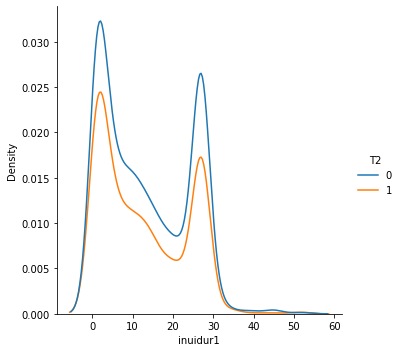

In [35]:
sns.displot(Penn, x='inuidur1', hue="T2", kind="kde")

Although both distributions don't show the same height, they actually have 
the same form, so, as such similarity is maintained along all the curve (for each distribution curve), we can suggest that the height discrepancy happens as a result of different proportionality of the control group with respect to the treatment group. Hence, both groups (control and treatment) have indeed the same distribution. 

## **Analysis**

# **Run all specifications**
We consider

- classical 2-sample approach, no adjustment (CL)
- classical linear regression adjustment (CRA)
- interactive regression adjusment (IRA) \

and carry out robust inference using the *estimatrR* packages.

### **Carry out covariate balance check**

In [44]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

#### **Classical 2-sample approach, no adjustment (CL)**

In [41]:
# model specifications
Penn['log_inuidur1'] = np.log(Penn['inuidur1'])
log_inuidur1 = pd.DataFrame(np.log(Penn['inuidur1'])).reset_index( drop = True )

Penn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5782 entries, 0 to 13911
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   abdt          5782 non-null   int64   
 1   tg            5782 non-null   int64   
 2   inuidur1      5782 non-null   int64   
 3   inuidur2      5782 non-null   int64   
 4   female        5782 non-null   int64   
 5   black         5782 non-null   int64   
 6   hispanic      5782 non-null   int64   
 7   othrace       5782 non-null   int64   
 8   dep           5782 non-null   category
 9   q1            5782 non-null   int64   
 10  q2            5782 non-null   int64   
 11  q3            5782 non-null   int64   
 12  q4            5782 non-null   int64   
 13  Unnamed: 13   5782 non-null   int64   
 14  q5            5782 non-null   int64   
 15  q6            5782 non-null   int64   
 16  recall        5782 non-null   int64   
 17  agelt35       5782 non-null   int64   
 18  agegt54

In [47]:
formula_cl = 'log_inuidur1 ~ T2'    
ols_cl = smf.ols(formula = formula_cl, data = Penn).fit().get_robustcov_results(cov_type = "HC1")

print(ols_cl.summary())

                            OLS Regression Results                            
Dep. Variable:           log_inuidur1   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     5.879
Date:                Sat, 30 Apr 2022   Prob (F-statistic):             0.0154
Time:                        19:17:45   Log-Likelihood:                -9344.7
No. Observations:                5782   AIC:                         1.869e+04
Df Residuals:                    5780   BIC:                         1.871e+04
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0568      0.021     98.158      0.0